# Matching

Контакты для связи: Данила Солтык, Telegram: [t.me/Danspers](https://t.me/Danspers)

## Описание проекта

**Matching** - это задача поиска и сопоставления двух объектов из разных наборов данных. Такая потребность возникла у маркетплейса, который имеет большой перечен товаров для продажи. На склад стали поступать новые партии товаров, которые имеет небольшие отличия в характеристиках. Технически, это выглядит как совершенно новые товары. Фактически это те эе товары, которые уже продаются на маркетплейсе. Задача сопоставить и связать новые товары со старыми, пользуясь совпадающими характеристиками.

**Что надо сделать?**
- разработать алгоритм, который для всех товаров из _validation.csv_ предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике `accuracy@5`.

$$
accuracy@n = \frac{\text{кол-во верных соотношений (из n предложенных)}} {\text{общее кол-во объектов}} * 100\%
$$

Именно в _предложении 5 кандидатов_ для соотношения и заключается отличительная черта данной метрики.

**Данные:** [источник](https://disk.yandex.ru/d/BBEphK0EHSJ5Jw)

- *base.csv* - анонимизированный набор товаров. Каждый товар представлен как уникальный **id** (`0-base, 1-base, 2-base, …`) и вектор признаков размерностью 72.
- *train.csv -* обучающий датасет. Каждая строчка - один товар, для которого известен уникальный **id** (`0-query, 1-query, …`) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- *validation.csv* - датасет с товарами (уникальный **id** и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *validation_answer.csv* - правильные ответы к предыдущему файлу.

**План работы:**
- Загрузить данные
- Понять задачу
- Подготовить данные
- Обучить модель (поиск ближайших соседей + ранжирование top-5)
- Измерить качество
- git commit
- Сделать лучше!

[Notion](https://praktikum.notion.site/06a8d64f2b2e429d8738fff6e2bcf371)

___

## Подготовка

В библиотеке [Scikit-Learn](https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-neighbors) существует метод поиска ближайших соседей, но весьма ресурсоёмкий из-за высокой точности вычислений. Поскольку исходный датасет имеет большой объём и абсолютная точность вычислений ближайших объектов не требуется, в этом проекте будет использована библиотека [Faiss](https://faiss.ai/index.html).

In [1]:
# импорт библиотек
import faiss
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler

Чтение датасетов, индексами в которых являются **id** товаров: `0-base, 1-base, 2-base, ... или 0-query, 1-query, ...`

In [2]:
df_base  = pd.read_csv('datasets/base.csv', index_col=0)
df_train = pd.read_csv('datasets/train.csv', index_col=0)
df_valid = pd.read_csv('datasets/validation.csv', index_col=0)
df_valid_ans = pd.read_csv('datasets/validation_answer.csv', index_col=0)

___

## Анализ данных

Для упрощения работы в следующей ячейке кода будет описана функция, которая выводит матрицу из графиков распределения значений всех колонок датасета. На вход ноа принимает один из исходных датасетов, и кол-во строк и столбцов в матрице. Для этих параметров уже заданы значения по-умолчанию, для вывода 72 графиков.

In [89]:
# Функция построения графиков распределения значений в колонках датасета (ver.3)

def show_graph_matrix(dataframe, color='blue', x=6, y=12):
    fig, axs = plt.subplots(y, x, figsize=(x*4, y*4))
    jx = 0 # накопитель
    for i in range(y):
        for j in range(x):
            column = str(i + j + jx)
            data = dataframe[column].value_counts().to_frame().reset_index().sort_values(by=column)
            axs[i, j].plot(column, 'count', data=data, marker='.', linestyle='', color=color)
            axs[i, j].set_title('Значения признака №' + column)
        jx += 5
    plt.show()

Для детального анализа конкретных колонок ниже описана функция, которая выводит top-5 популярных значений (и частоту их повторений), а так же графики распределения этих значений в разных масштабах (общий и увеличенный).

In [90]:
# Функция для подробного анализа значений колонки

def value_analysis(dataframe, column:str, ylim_max:float, color='blue'):
    print('Наиболее популярные значения')
    display((dataframe[column].value_counts(normalize=True)
                              .sort_values(ascending=False)*100)
                              .to_frame()
                              .rename(columns={column:'values','proportion':'frequency, %'})
                              .head())

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    axs[0].plot((dataframe[column].value_counts(normalize=True).sort_index() * 100), marker='.', linestyle='', color=color)
    axs[0].set_title('График распределения значений колонки №' + column + ' (общий вид)')
    axs[0].set_ylabel('Доля объектов от общего количества, %')
    axs[0].set_xlabel('Значения признака №' + column)
    axs[0].grid()

    axs[1].plot((dataframe[column].value_counts(normalize=True).sort_index() * 100), marker='o', linestyle='', color=color)
    axs[1].set_title('График распределения значений колонки №' + column + ' (увеличенный вид)')
    axs[1].set_ylabel('Доля объектов от общего количества, %)')
    axs[1].set_xlabel('Значения признака №' + column)
    axs[1].set_ylim(0, ylim_max)
    axs[1].grid()
    plt.show()

In [85]:
# Функция построения графиков распределения значений всех датасетов (ver.2)

def show_general_matrix(df_1, df_2, df_3, x=6, y=12):
    fig, axs = plt.subplots(y, x, figsize=(x*4, y*4))
    
    jx = 0 # накопитель
    for i in range(y):
        for j in range(x):
            column = str(i + j + jx)

            data_1 = df_1[column].value_counts(normalize=True).sort_index() * 100
            data_2 = df_2[column].value_counts(normalize=True).sort_index() * 100
            data_3 = df_3[column].value_counts(normalize=True).sort_index() * 100
            
            axs[i, j].plot(data_1, marker='o', linestyle='', color='lightblue')
            axs[i, j].plot(data_2, marker='+', linestyle='', color='red')
            axs[i, j].plot(data_3, marker='x', linestyle='', color='lightgreen')
            axs[i, j].set_title('Значения признака №' + column)
        jx += 5
    plt.show()

### Base

`Base` - набор из всех товаров (когда либо продававшихся на маркетплейсе) и 72 колонки с их характеристиками. Фактическое значение этих характеристик не имеет значения в рамках этого проекта. Эти данные прошли предварительную обработку (анонимизацию). По этой причине значения выглядят совершенно абстрактными на первый взгляд.

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   0       2918139 non-null  float64
 1   1       2918139 non-null  float64
 2   2       2918139 non-null  float64
 3   3       2918139 non-null  float64
 4   4       2918139 non-null  float64
 5   5       2918139 non-null  float64
 6   6       2918139 non-null  float64
 7   7       2918139 non-null  float64
 8   8       2918139 non-null  float64
 9   9       2918139 non-null  float64
 10  10      2918139 non-null  float64
 11  11      2918139 non-null  float64
 12  12      2918139 non-null  float64
 13  13      2918139 non-null  float64
 14  14      2918139 non-null  float64
 15  15      2918139 non-null  float64
 16  16      2918139 non-null  float64
 17  17      2918139 non-null  float64
 18  18      2918139 non-null  float64
 19  19      2918139 non-null  float64
 20  20      2918139 non

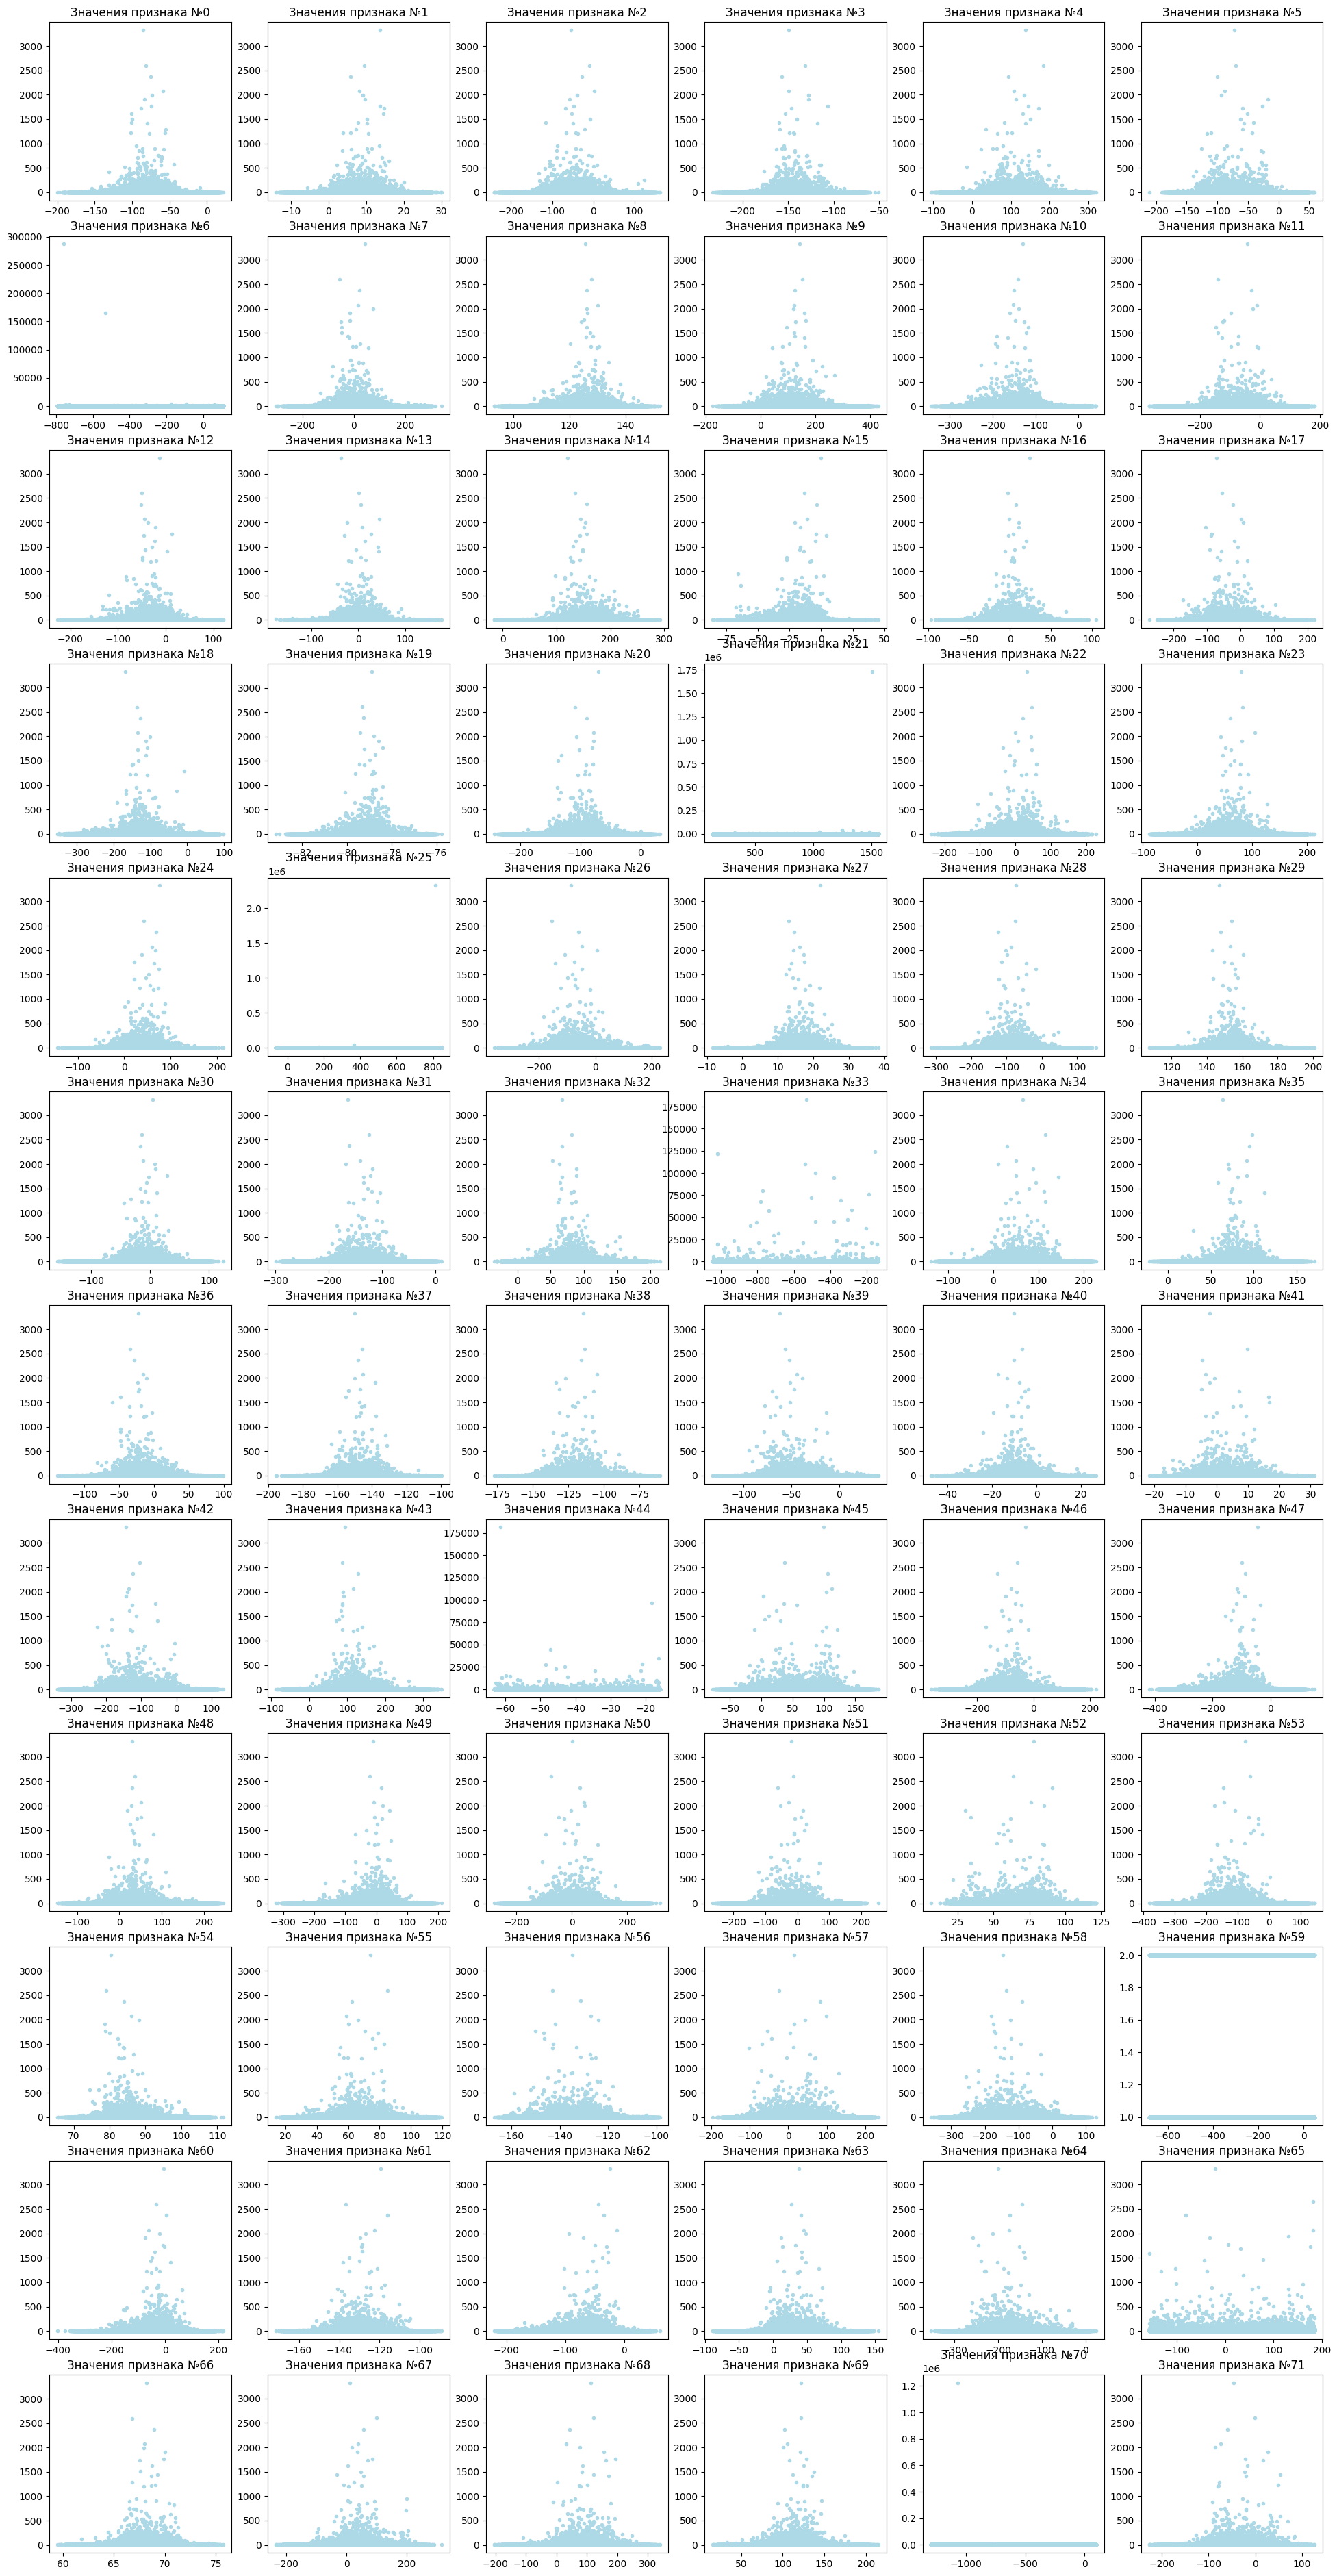

In [86]:
display(df_base.head())
print(df_base.info(verbose=True, show_counts=True))
print('Кол-во товаров-дубликатов:', df_base.duplicated().sum())
show_graph_matrix(df_base)

Большинство данных имеют вид _нормального распределения_ или очень схожего. В каждой колонке свой диапазон значений (широкий/узкий), встречаются как положительные та и отрицательные значения. Отдельное внимание стоит уделить столбцам №№ `6, 21, 25, 44, 45, 59, 65, 70`.

Наиболее популярные значения


,"frequency, %"
6,
-759.626065,9.838119
-530.124724,5.647949
-175.047853,0.127033
-92.055125,0.124120
-750.151074,0.091120


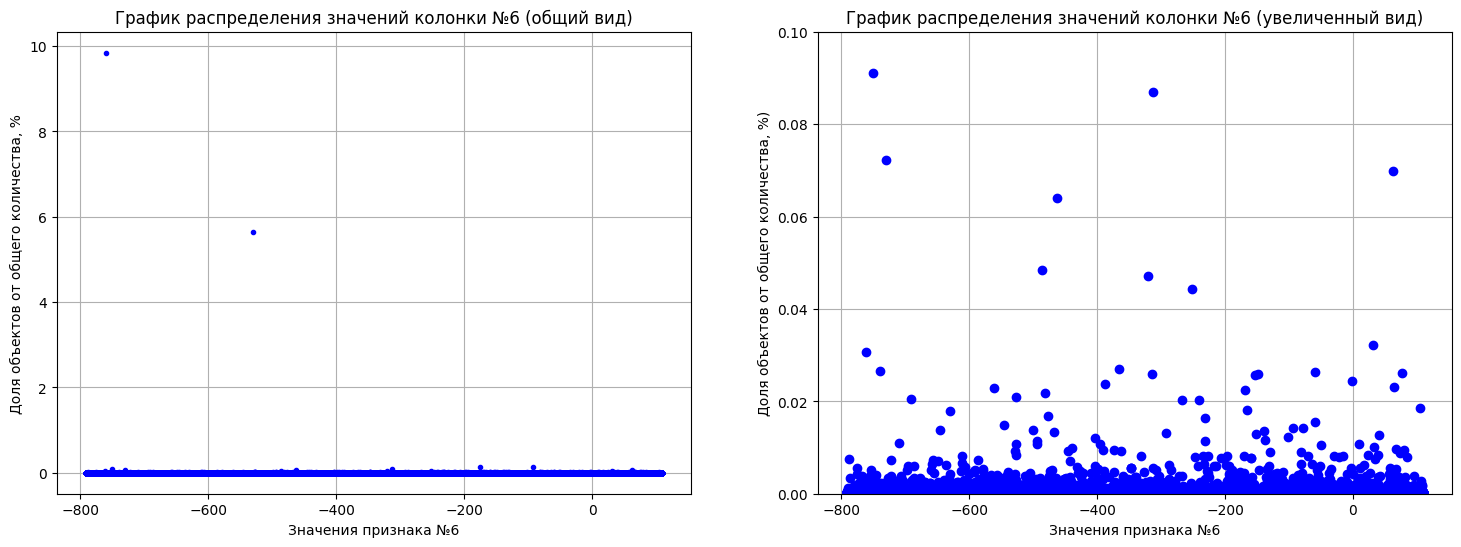

In [91]:
# распределение значений колонки №6
value_analysis(df_base, '6', 0.1)

Пара значений (-759.626065, -530.124724) особо выделяются. Они встречаются почти у 10% и 5% товаров, соответственно. Остальные значения не выделяются особой популярностью, и распределены равномерно на протяжении всего диапазона.

Наиболее популярные значения


,"frequency, %"
21,
1507.231274,59.214486
1248.126198,1.397603
1342.641120,1.128562
1483.714136,0.804828
1054.205600,0.683689


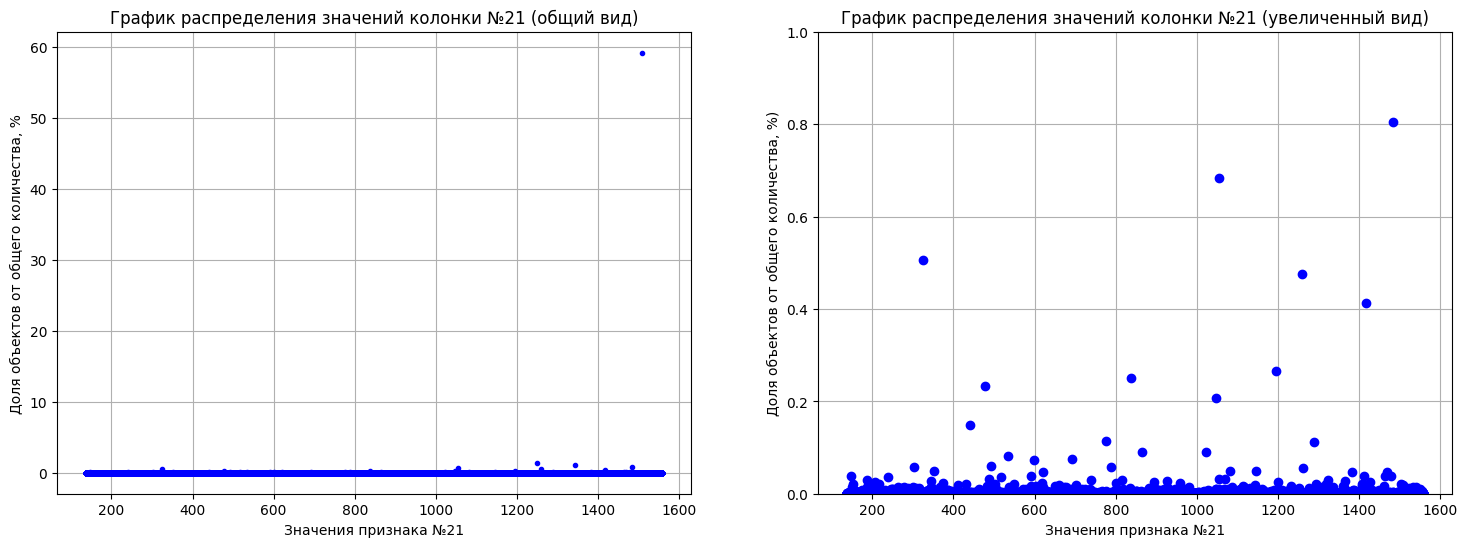

In [92]:
# распределение значений колонки №21
value_analysis(df_base, '21', 1)

Значений 1507.231274 особо популярно, встречается у ~60%. Остальные значения не популярны. Это отчётливо видно на графиках. В том числе их равномерное распределение на протяжении всего диапазона.

Наиболее популярные значения


,"frequency, %"
25,
813.770071,79.626776
366.779583,1.480670
175.595709,0.225658
514.955051,0.045543
701.226241,0.042150


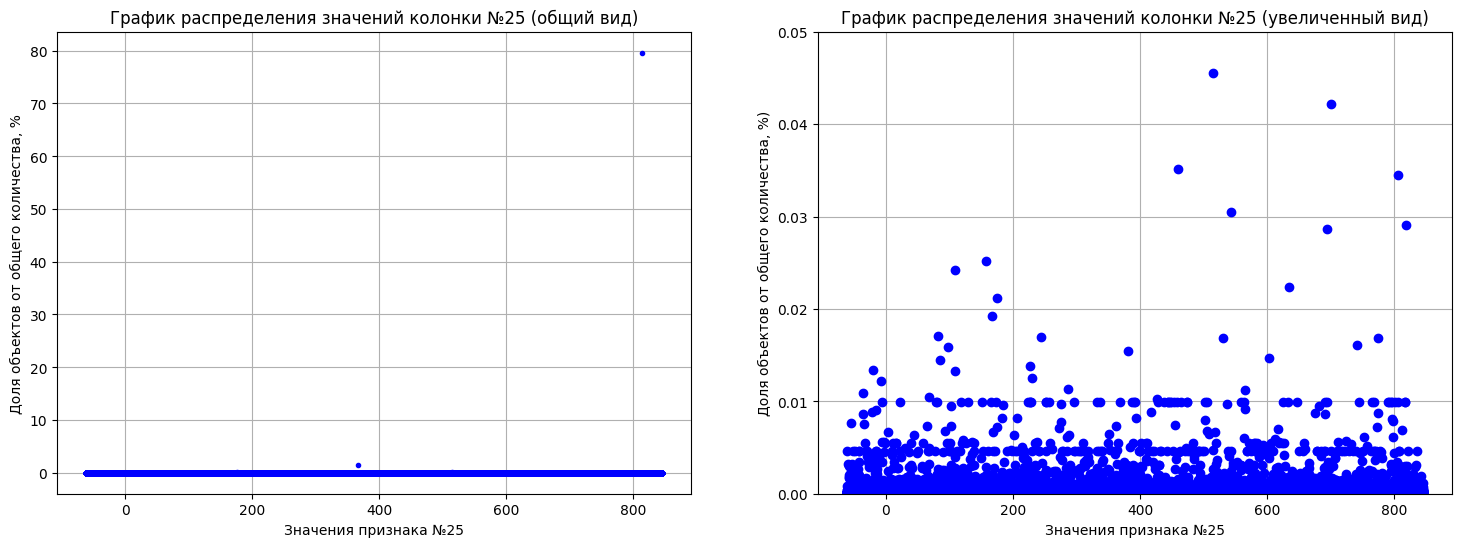

In [93]:
# распределение значений колонки №25
value_analysis(df_base, '25', 0.05)

Пара значений (813.770071, 813.770071) особо выделяются. Они встречаются почти у 80% и 1,5% товаров, соответственно. Остальные значения не выделяются особой популярностью, и распределены равномерно на протяжении всего диапазона. На увеличенном графике (справа) прослеживается явная закономерность. Некоторые значения встречаются с равной частотой. Возможно, это закодированный цвет товара.

Наиболее популярные значения


,"frequency, %"
44,
-61.441417,6.209197
-18.251750,3.321226
-47.166102,1.526212
-16.440254,1.192849
-21.092403,0.965958


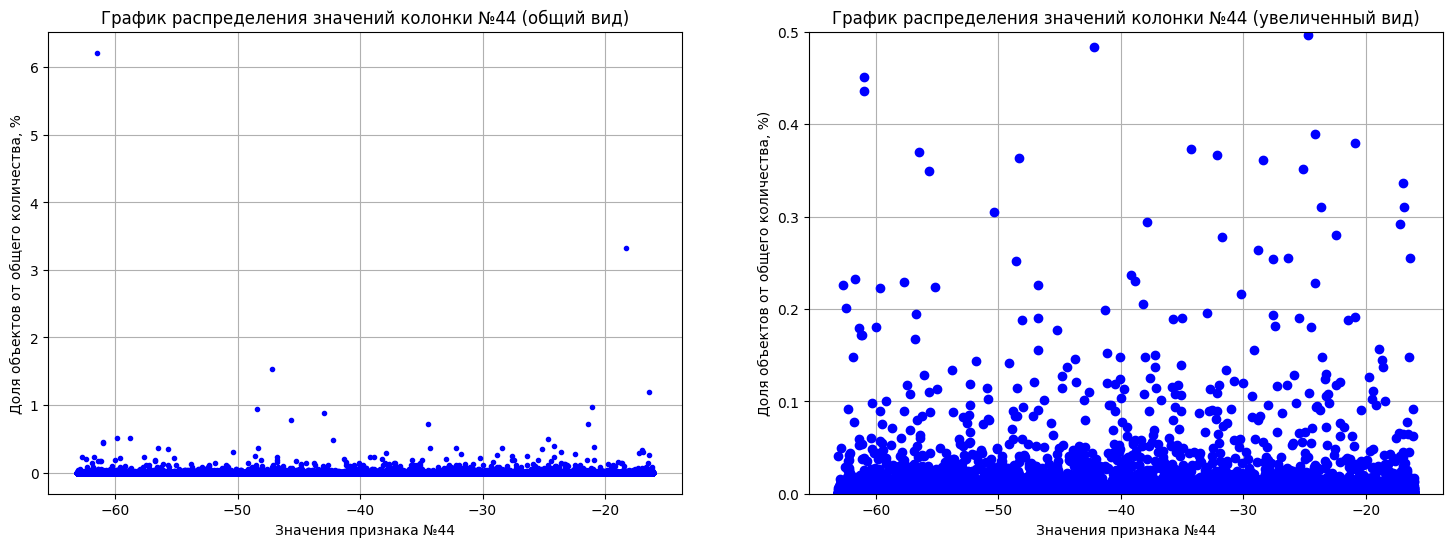

In [94]:
# распределение значений колонки №44
value_analysis(df_base, '44', 0.5)

Аналогичная ситуация. Пара популярных значений, а все остальные равномерно распределены по всему диапазону.

Значения встречающиеся в колонке №56: [   5.14971423 -251.95235755 -529.39695637 ... -509.1430963  -268.43850644
 -409.24383652] 

Соотношение товаров и уникальность значений их параметра №59
       кол-во товаров
count                
1             2913989
2                2075
Наиболее популярные значения


,"frequency, %"
59,
-230.403784,0.000069
-13.211805,0.000069
-82.038490,0.000069
-188.534014,0.000069
-651.846315,0.000069


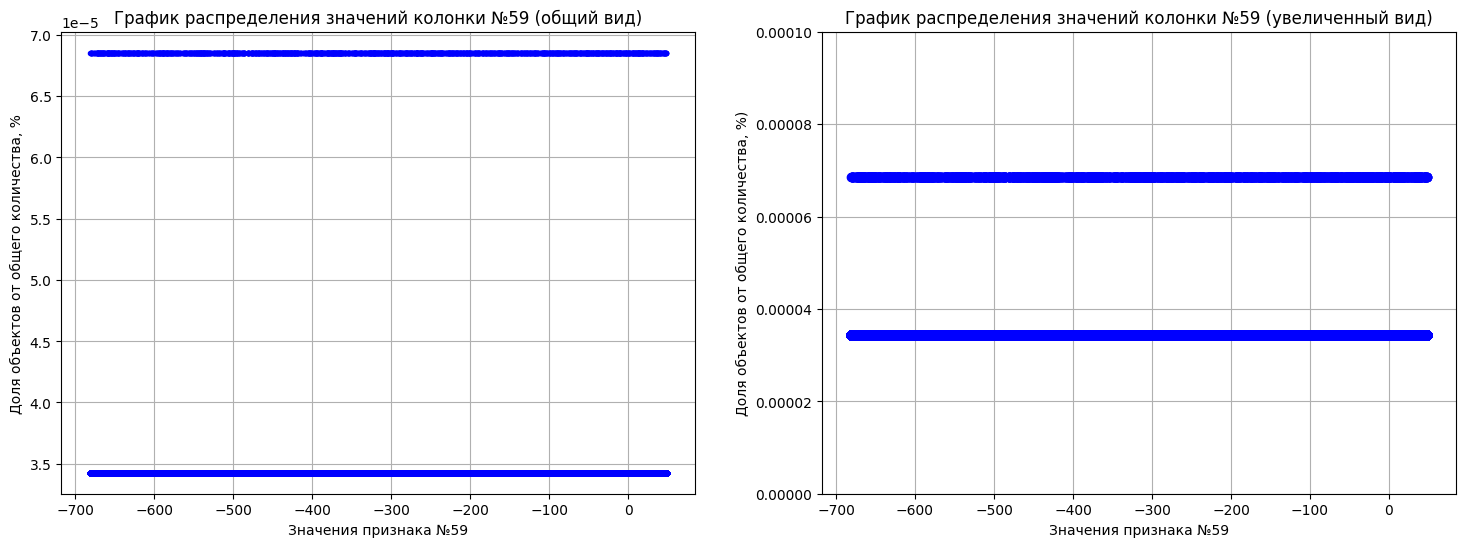

In [95]:
# анализ колонки №59
print('Значения встречающиеся в колонке №56:', df_base['59'].unique(), '\n')

print('Соотношение товаров и уникальность значений их параметра №59')
print(df_base['59'].value_counts().sort_values(ascending=False).value_counts().to_frame().rename(columns={'count':'кол-во товаров'}))

value_analysis(df_base, '59', 0.0001)

Почти у каждого товара этот параметр уникальный и не повторяется. В от 2075 товаров, которые заимствуют этот параметр от другого товара.

Наиболее популярные значения


,"frequency, %"
65,
-21.533007,0.113703
181.959582,0.091085
-81.475771,0.081113
182.446349,0.070696
130.450168,0.066207


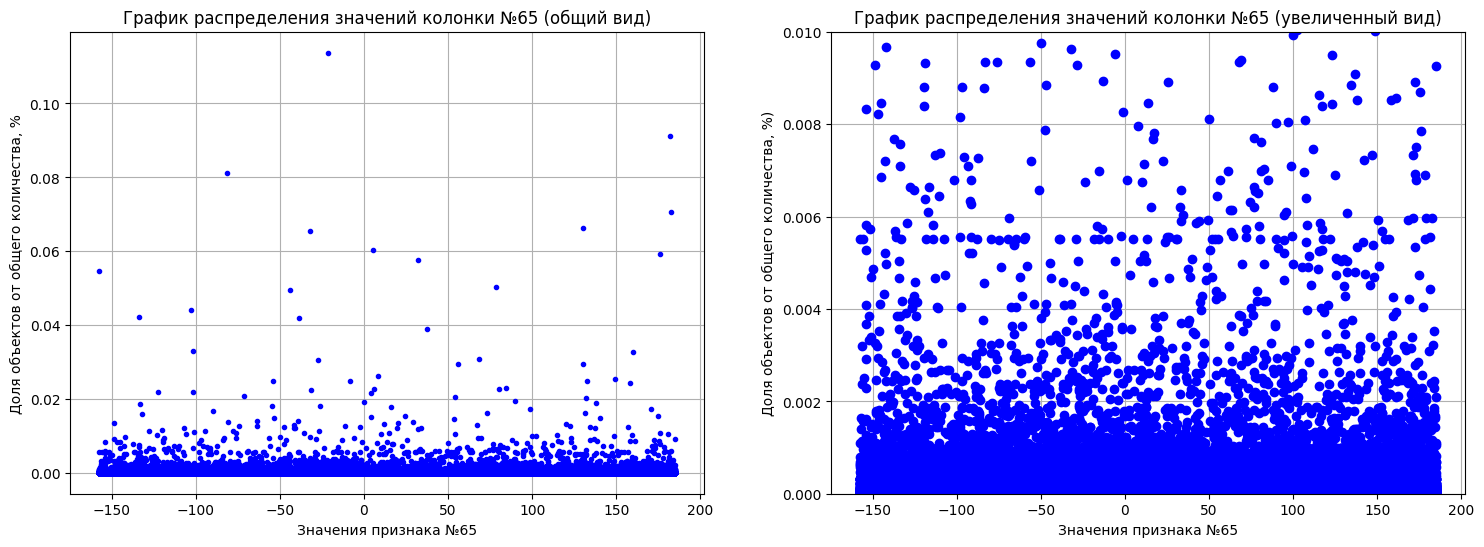

In [96]:
# распределение значений колонки №65
value_analysis(df_base, '65', 0.01)

Равномерное распределение значений, за редкими исключениями определённых значений.

Наиболее популярные значения


,"frequency, %"
70,
-1074.464888,41.923877
-782.676180,0.235321
-597.491204,0.028957
-799.363667,0.005106
-891.219087,0.005072


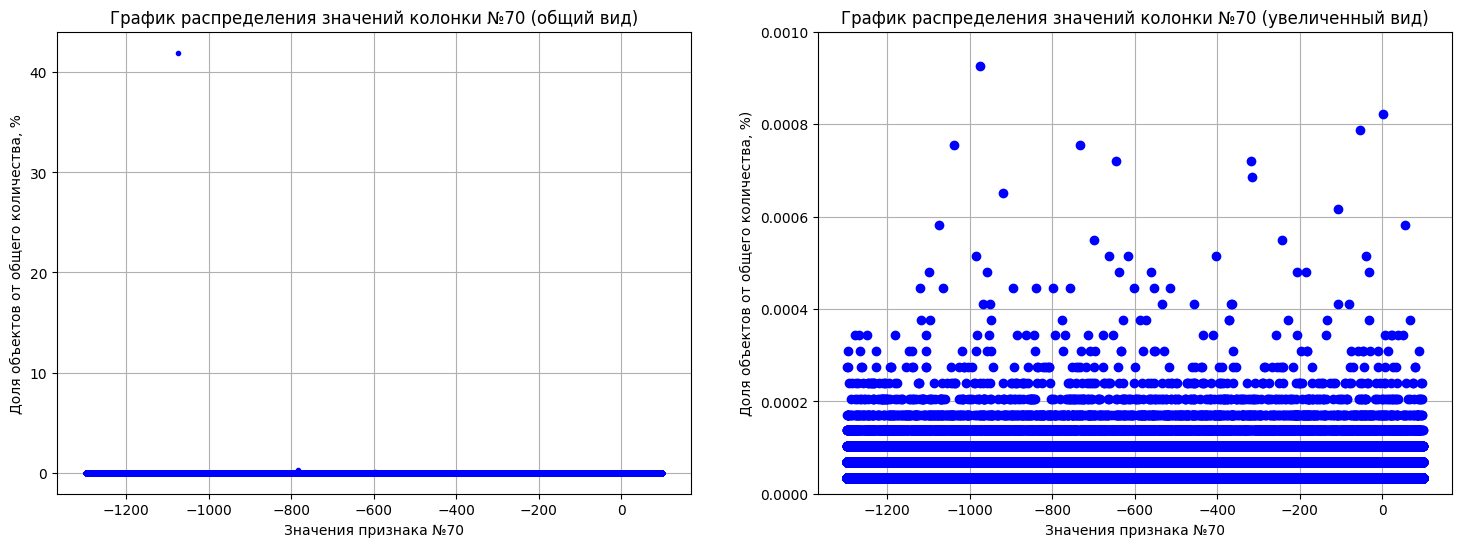

In [97]:
# распределение значений колонки №70
value_analysis(df_base, '70', 0.001)

Особо популярное значение (-1074.464888) встречающее более чем у 40% товаров. Остальные значения распределены равномерно на протяжении всего диапазона. На увеличенном графике (справа) прослеживается явная дискретность частоты повторения значений.

Общий вывод по данным: значения распределены равномерно. Выбросы отсутствуют.

### Train

`Train` - набор из товаров новых поставок, для которых известны соответствующие товары из "старого" датасета base. ID этого товара содержится в отдельном датасете target.

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

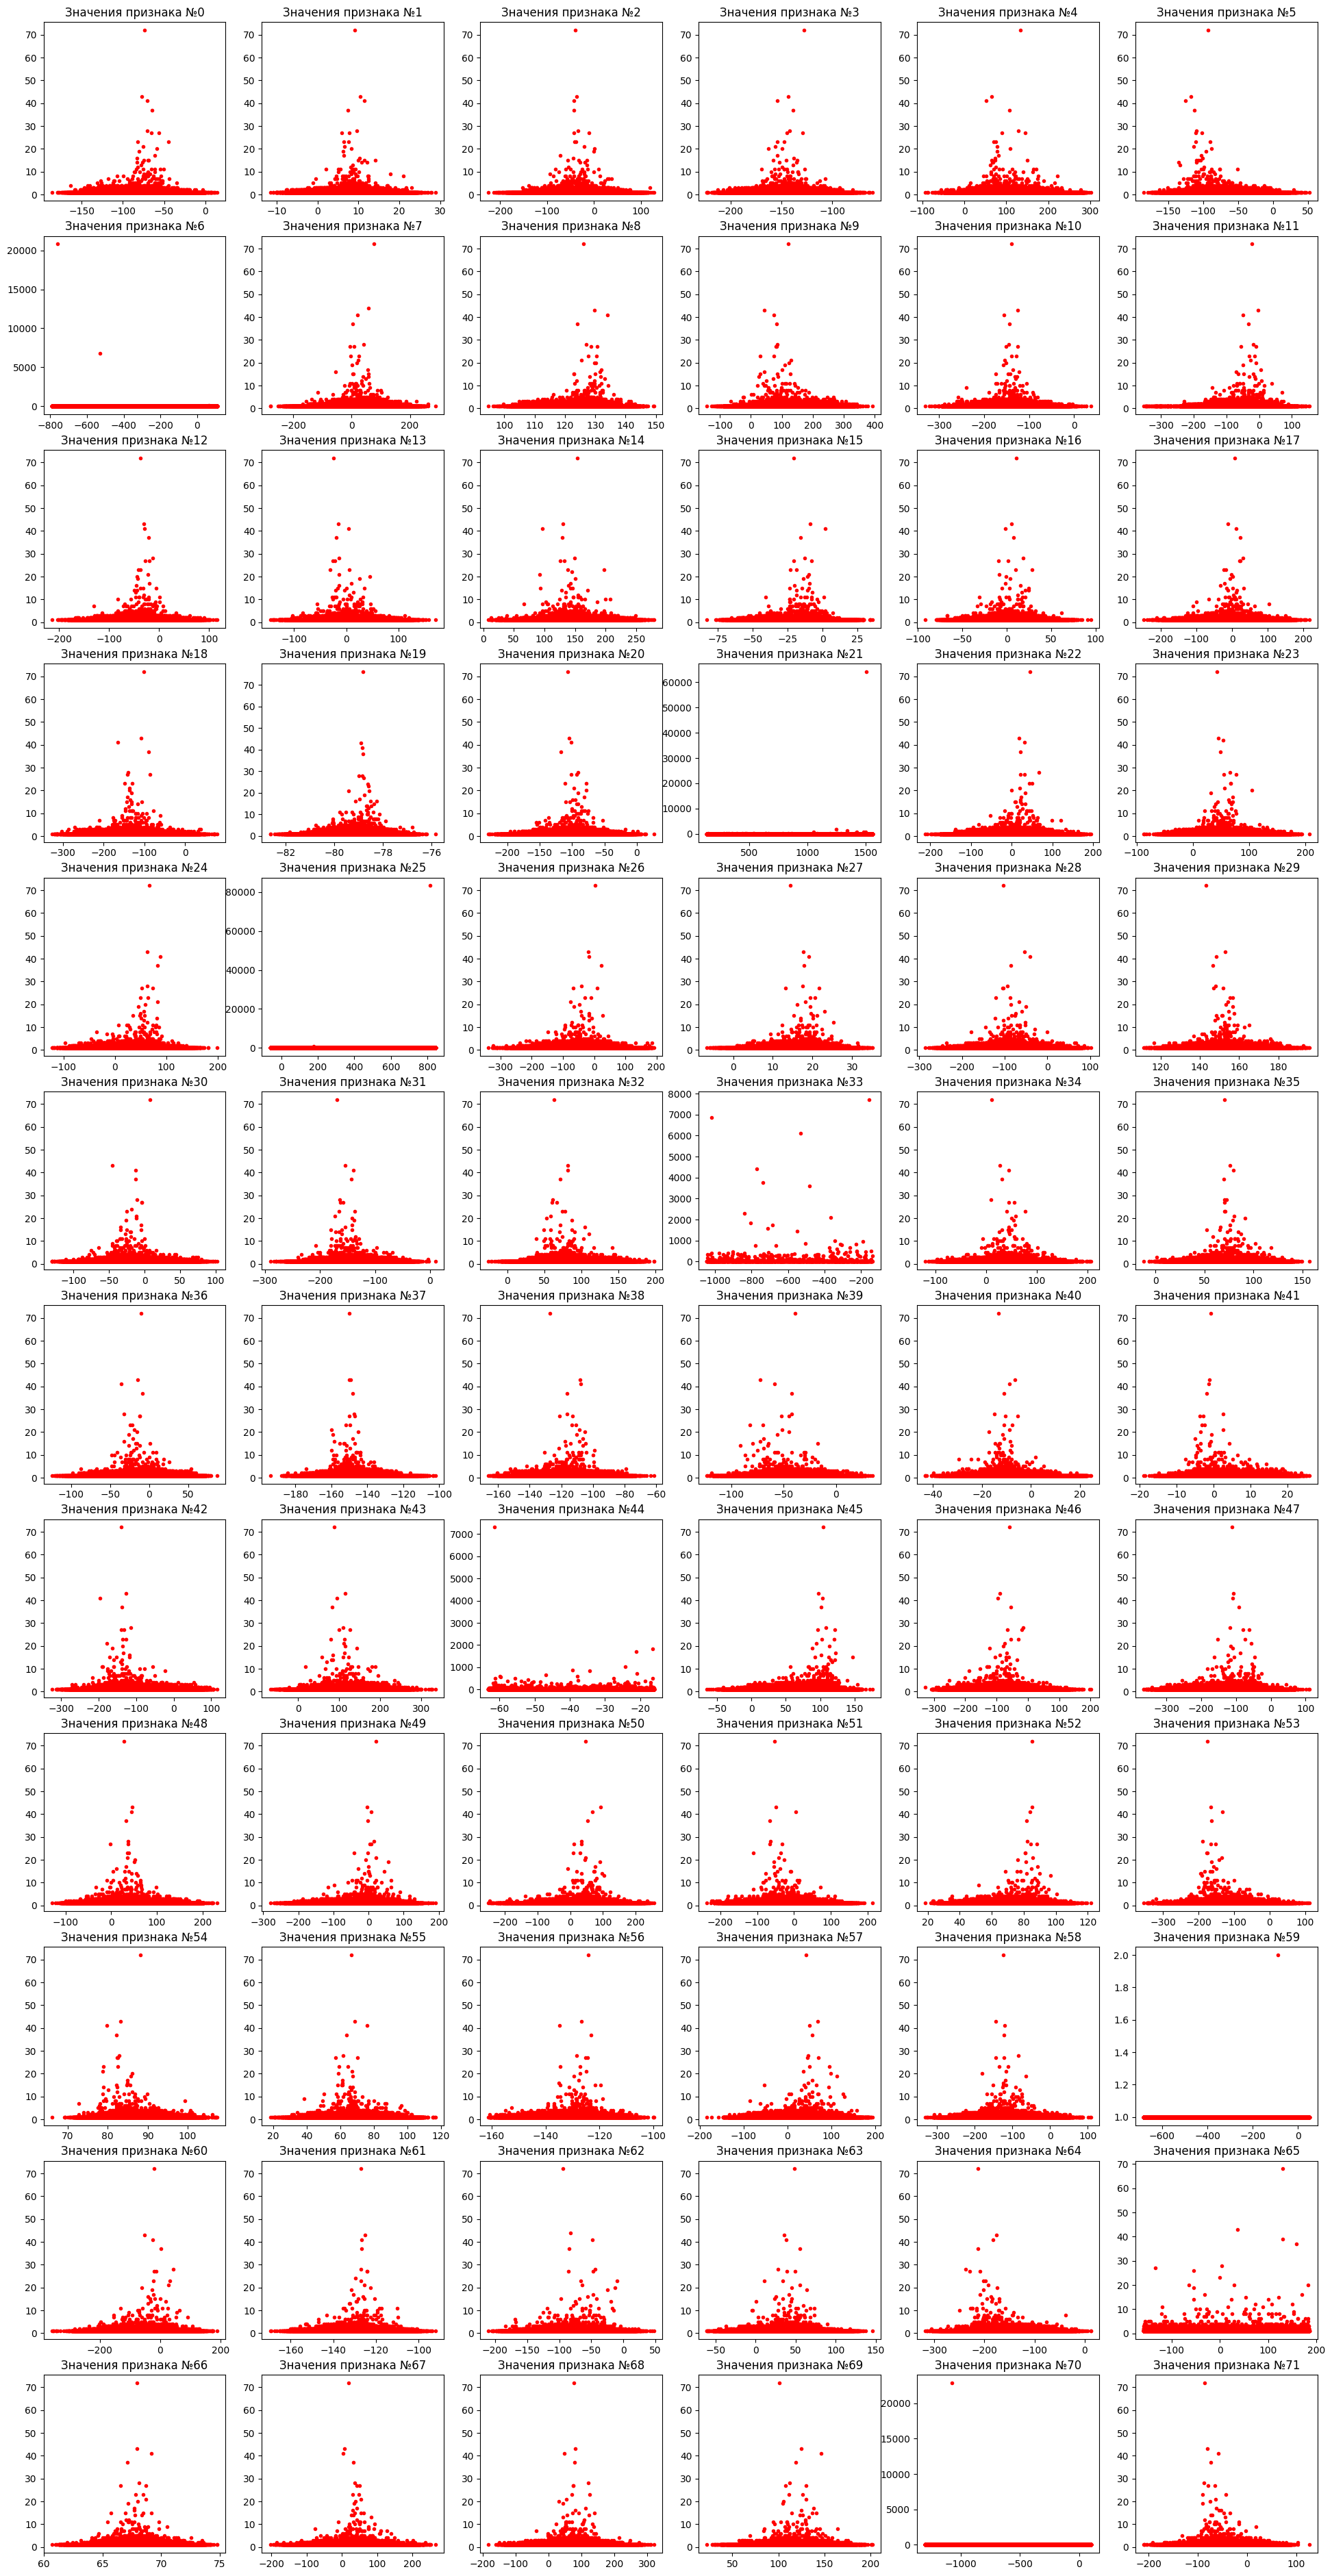

In [82]:
display(df_train.head())
df_train.info()
print('Кол-во товаров-дубликатов:', df_train.duplicated().sum())
show_graph_matrix(df_train, color='red')

Тренировочные данные имеют аналогичный вид как в base.csv. Значения параметров №№ `6, 21, 25, 44, 45, 59, 65, 70` распределены равномерно на всём диапазоне. Встречаются особо популярные значения. Большинство данных имеют вид _нормального распределения_ или очень схожего.

Наиболее популярные значения


,"frequency, %"
6,
-759.626065,9.838119
-530.124724,5.647949
-175.047853,0.127033
-92.055125,0.124120
-750.151074,0.091120


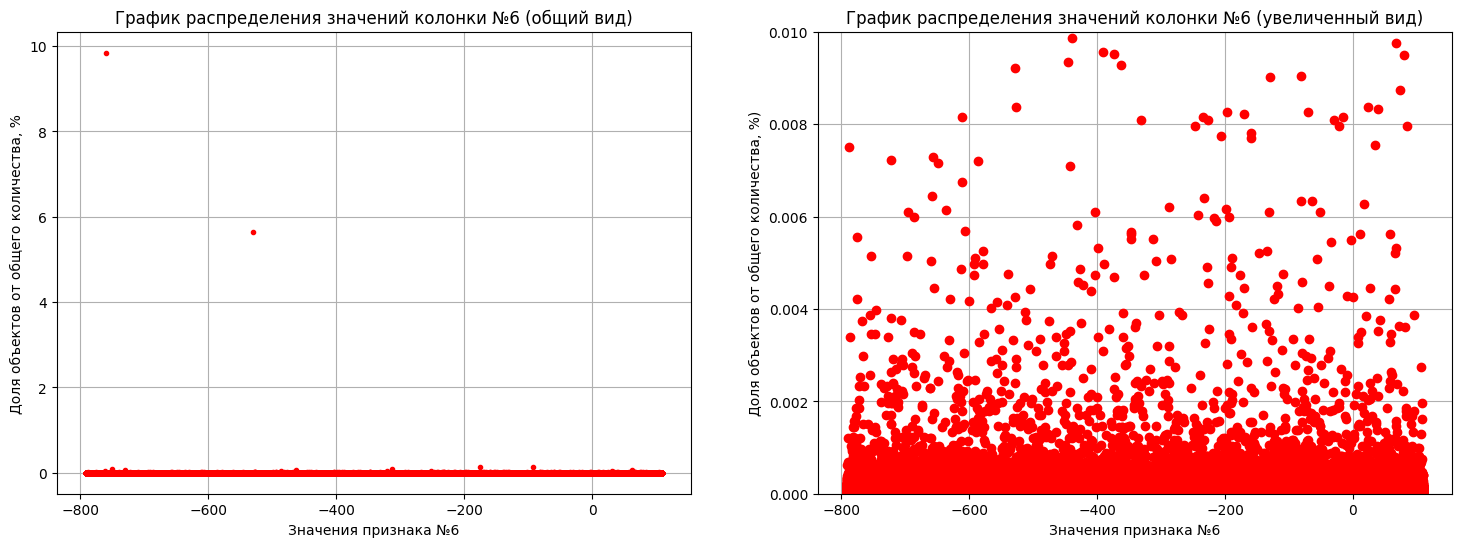

In [100]:
# распределение значений колонки №6
value_analysis(df_base, '6', 0.01, 'red')

Наиболее популярные значения


,"frequency, %"
21,
1507.231274,59.214486
1248.126198,1.397603
1342.641120,1.128562
1483.714136,0.804828
1054.205600,0.683689


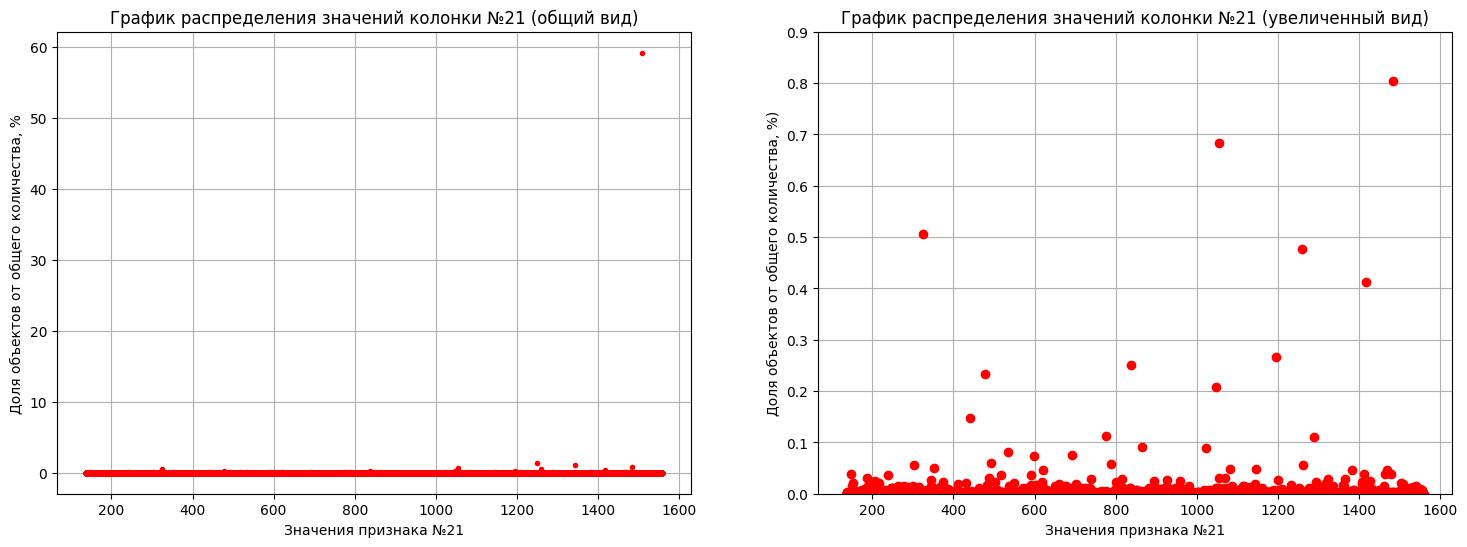

In [102]:
# распределение значений колонки №21
value_analysis(df_base, '21', 0.9, 'red')

Наиболее популярные значения


,"frequency, %"
25,
813.770071,79.626776
366.779583,1.480670
175.595709,0.225658
514.955051,0.045543
701.226241,0.042150


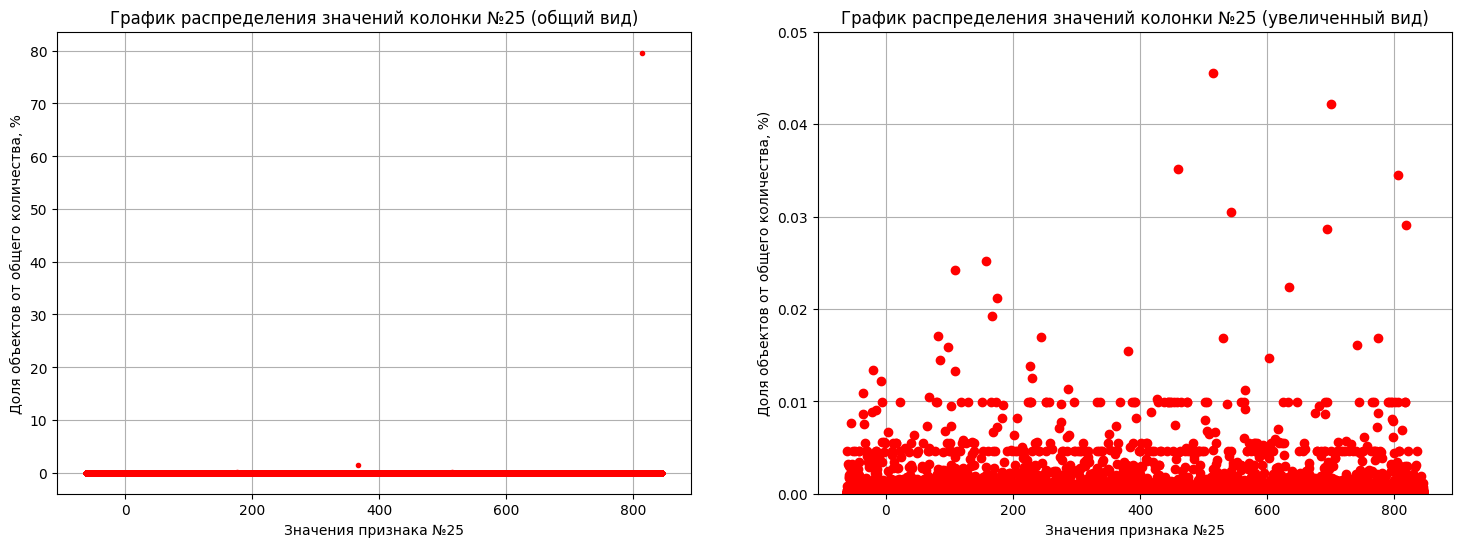

In [103]:
# распределение значений колонки №25
value_analysis(df_base, '25', 0.05, 'red')

Наиболее популярные значения


,"frequency, %"
44,
-61.441417,6.209197
-18.251750,3.321226
-47.166102,1.526212
-16.440254,1.192849
-21.092403,0.965958


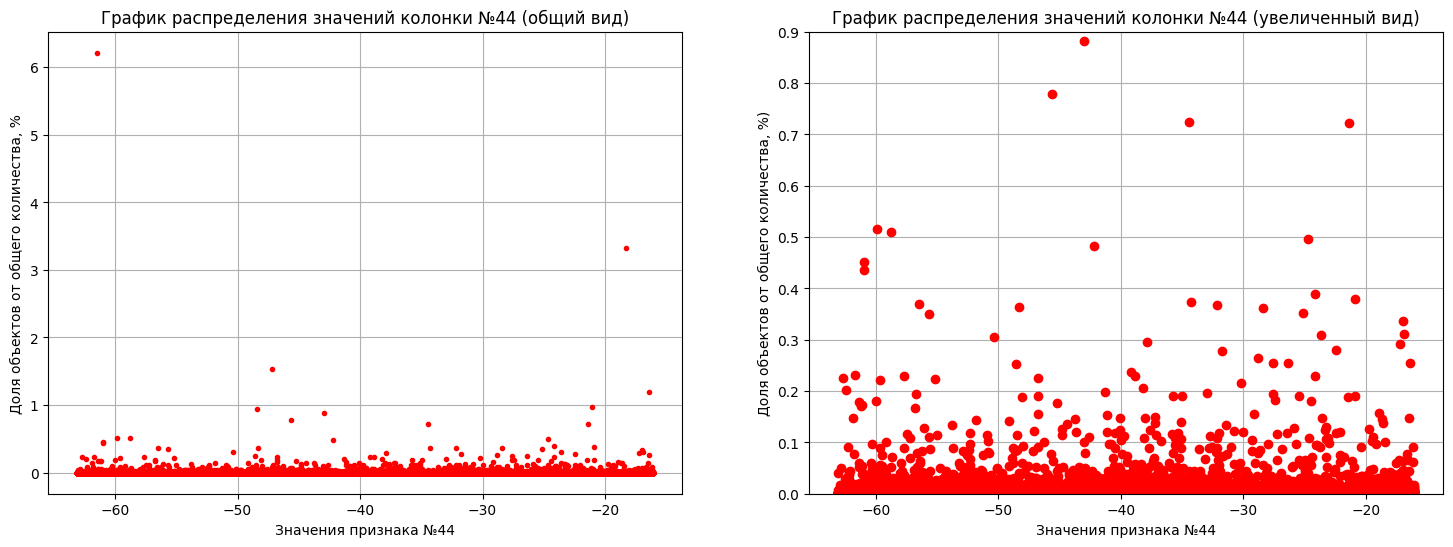

In [104]:
# распределение значений колонки №44
value_analysis(df_base, '44', 0.9, 'red')

Наиболее популярные значения


,"frequency, %"
45,
99.057945,0.113840
37.765175,0.089064
106.433525,0.081250
113.029050,0.071004
103.809310,0.068331


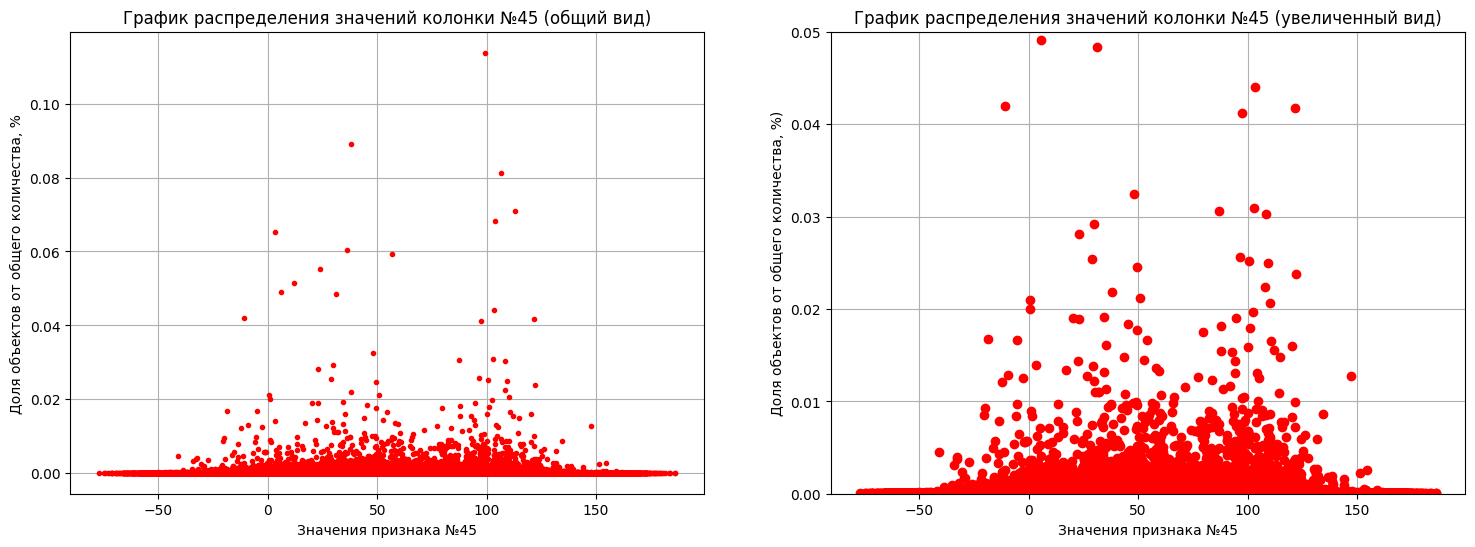

In [105]:
# распределение значений колонки №45
value_analysis(df_base, '45', 0.05, 'red')

Наиболее популярные значения


,"frequency, %"
59,
-230.403784,0.000069
-13.211805,0.000069
-82.038490,0.000069
-188.534014,0.000069
-651.846315,0.000069


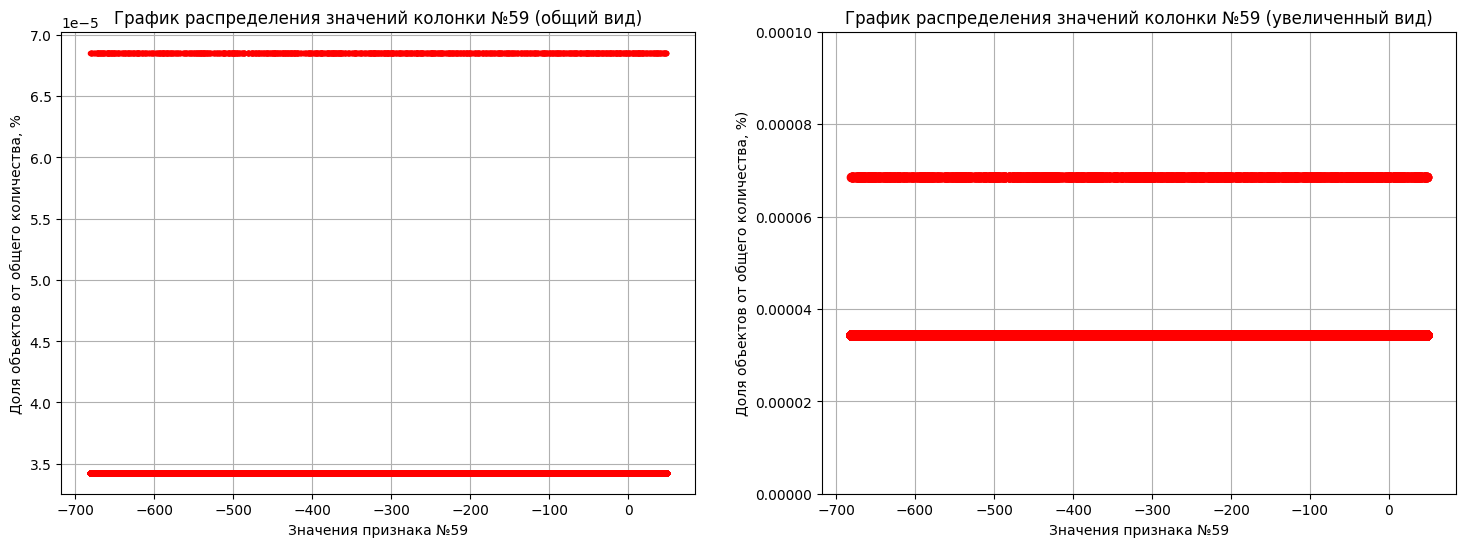

In [108]:
# распределение значений колонки №59
value_analysis(df_base, '59', 0.0001, 'red')

Наиболее популярные значения


,"frequency, %"
65,
-21.533007,0.113703
181.959582,0.091085
-81.475771,0.081113
182.446349,0.070696
130.450168,0.066207


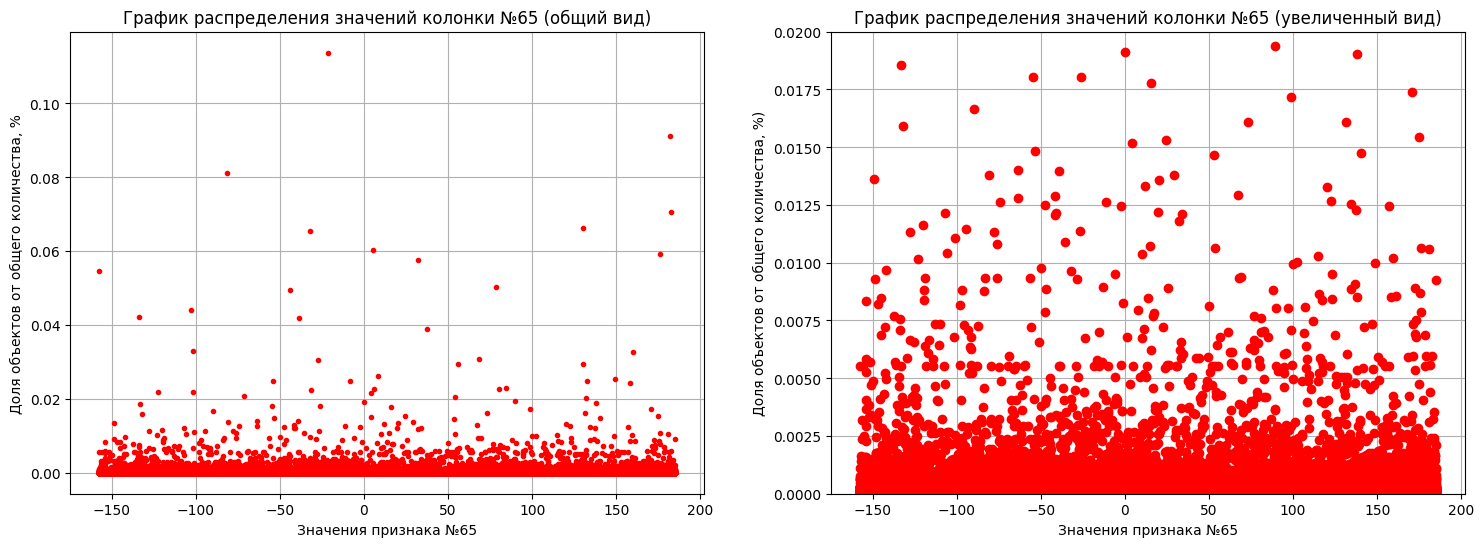

In [109]:
# распределение значений колонки №65
value_analysis(df_base, '65', 0.02, 'red')

Наиболее популярные значения


,"frequency, %"
70,
-1074.464888,41.923877
-782.676180,0.235321
-597.491204,0.028957
-799.363667,0.005106
-891.219087,0.005072


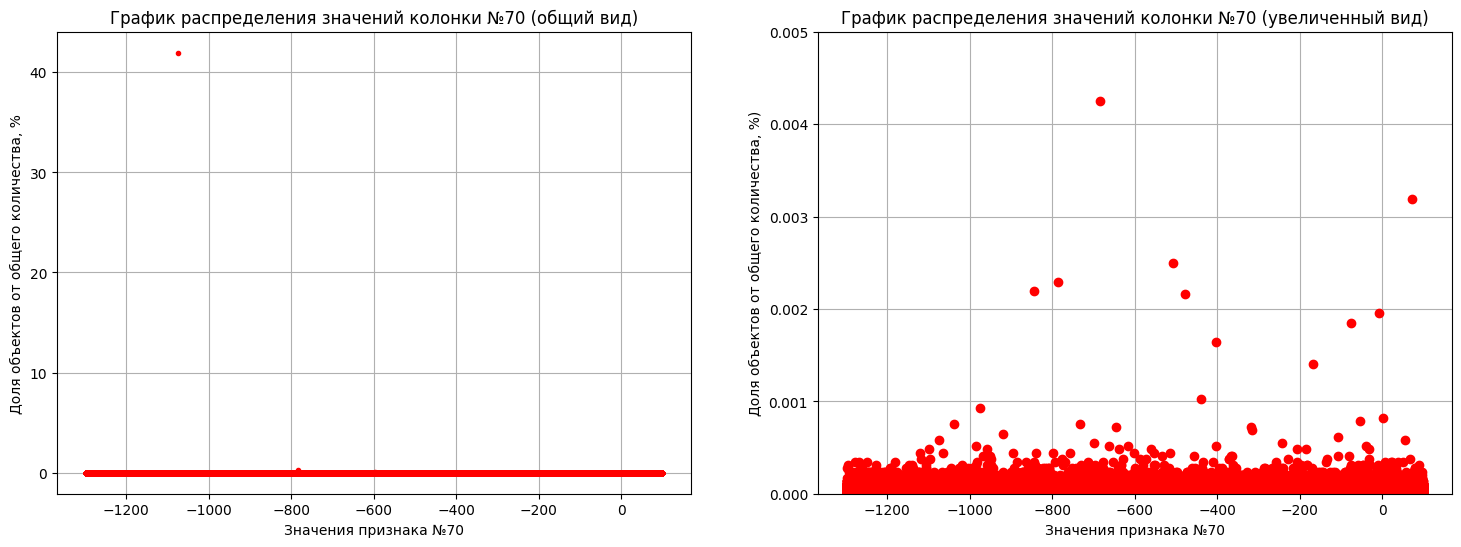

In [110]:
# распределение значений колонки №70
value_analysis(df_base, '70', 0.005, 'red')

### Valid

`Valid` - набор из товаров новых поставок, для которых НЕ известны соответствующие товары и их необходимо найти.

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

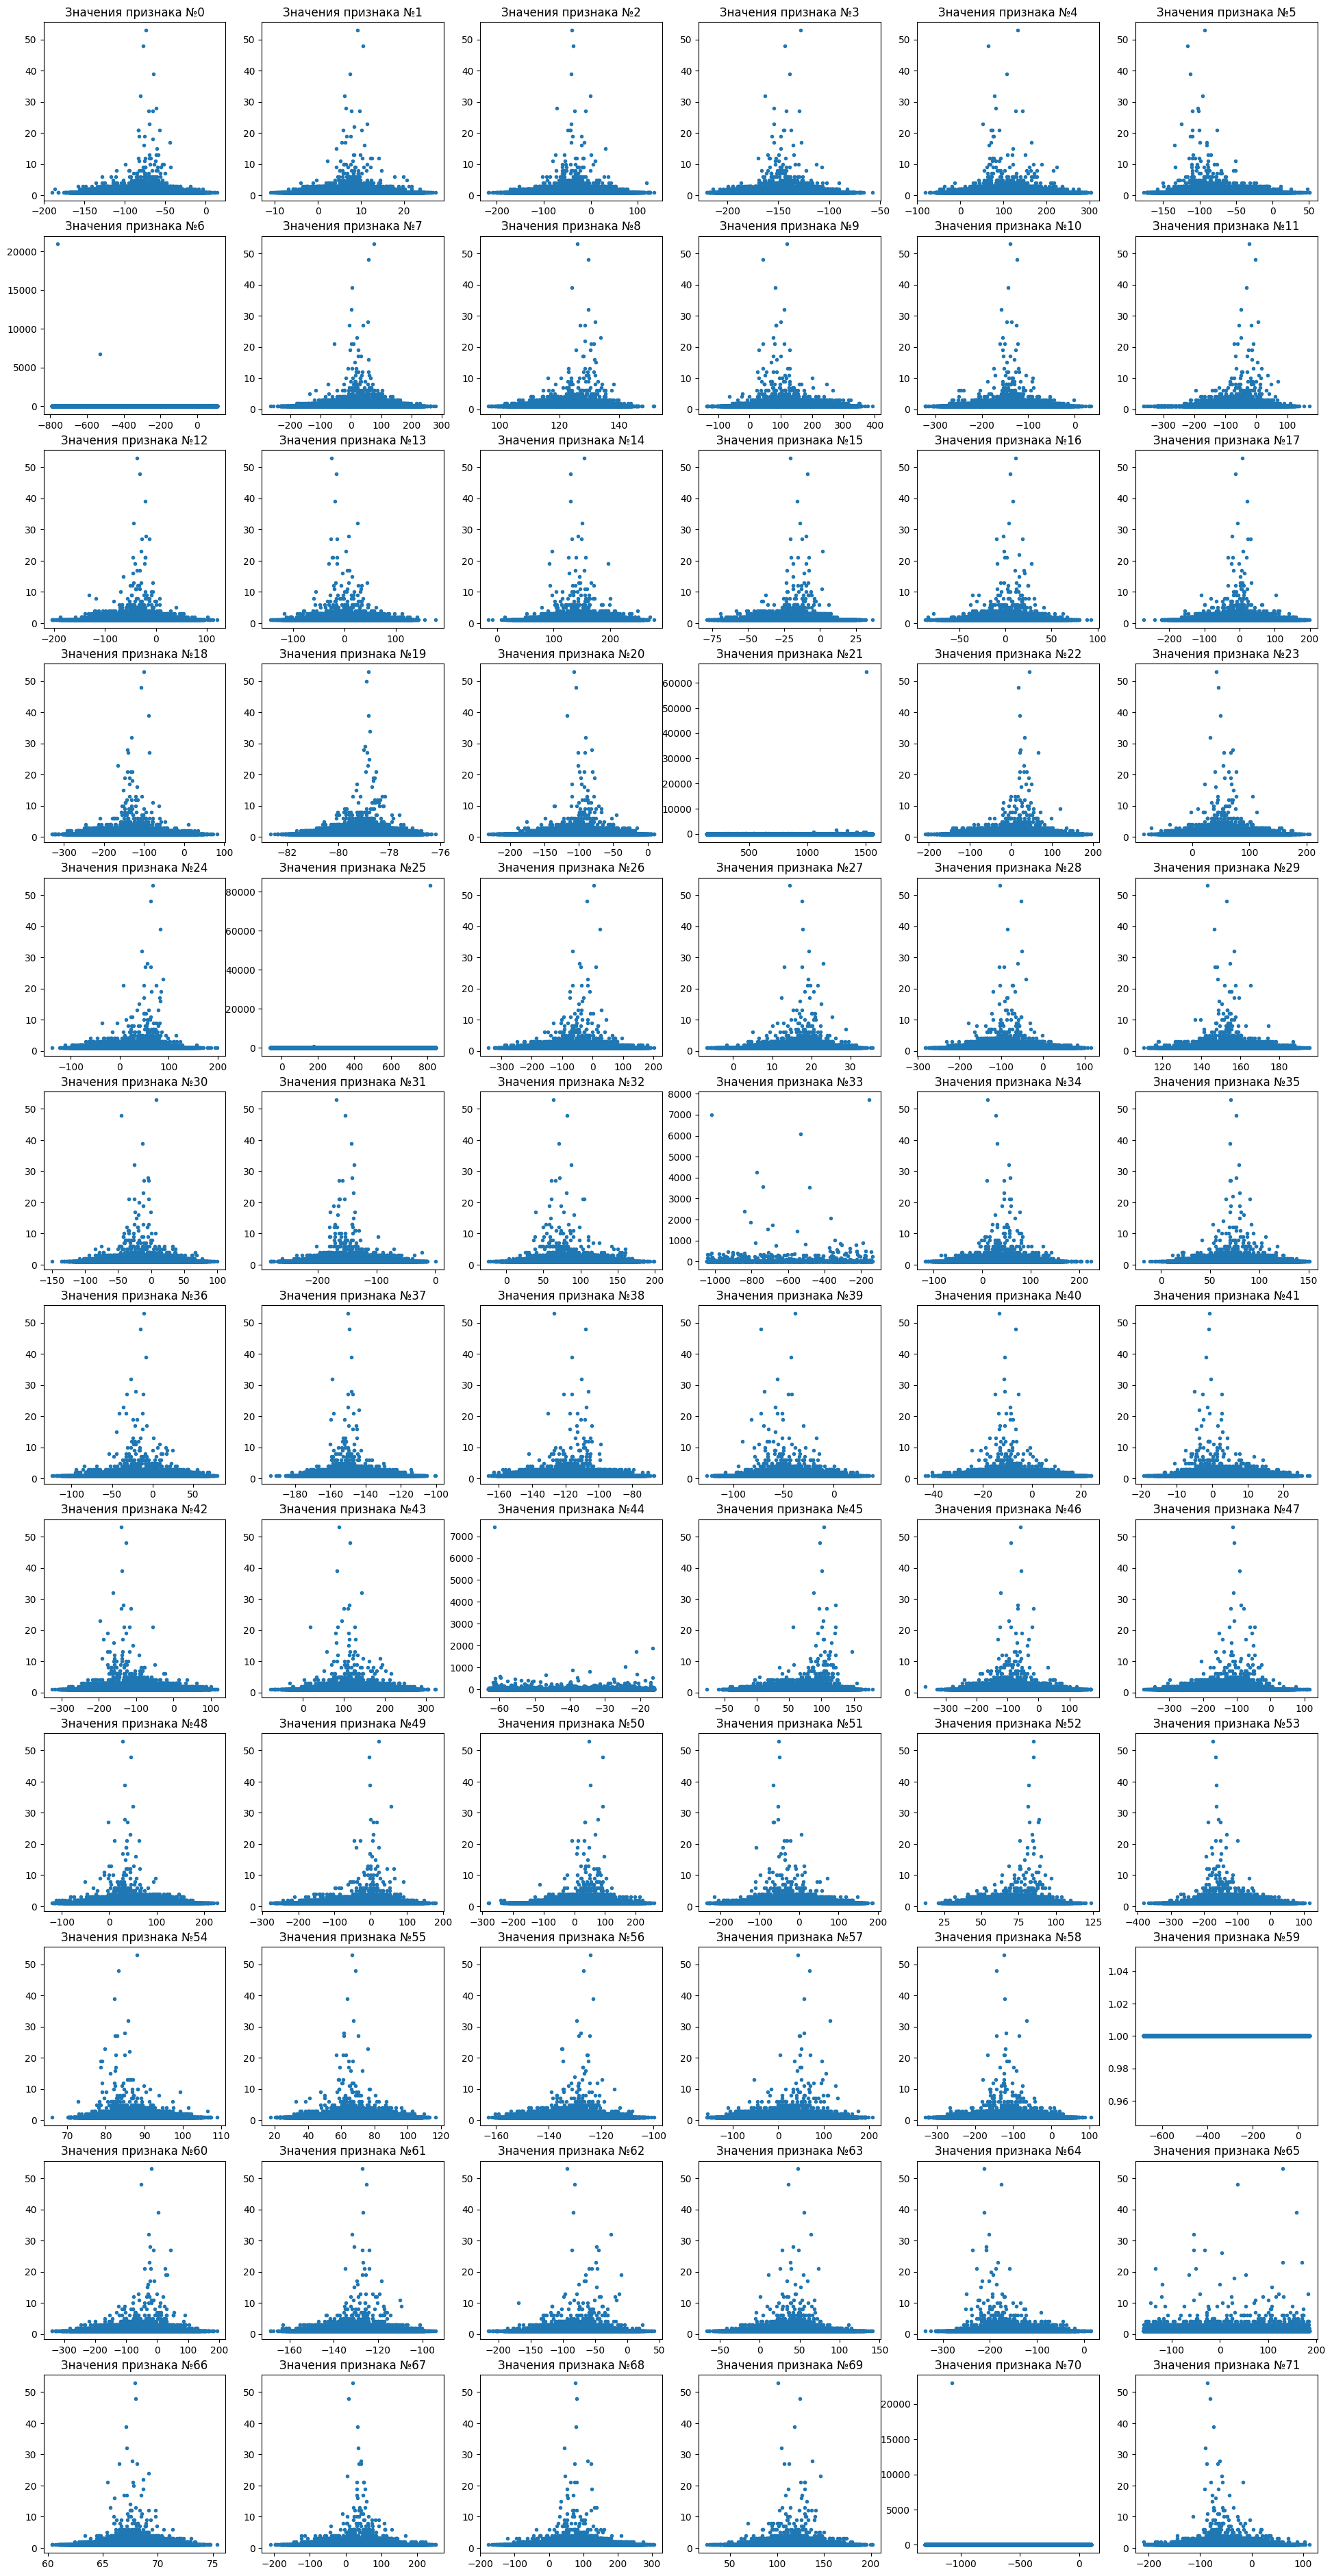

In [34]:
display(df_valid.head())
df_valid.info()
print('Кол-во товаров-дубликатов:', df_valid.duplicated().sum())
show_graph_matrix(df_valid)

`Valid_answer` - верные соответствующие товары для выборки Valid. Необходимо для тестирования обученной модели.

In [30]:
display(df_valid_ans.head())
df_valid_ans.info()
print('Кол-во товаров-дубликатов:', df_valid_ans.duplicated().sum())

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB
Кол-во товаров-дубликатов: 8498


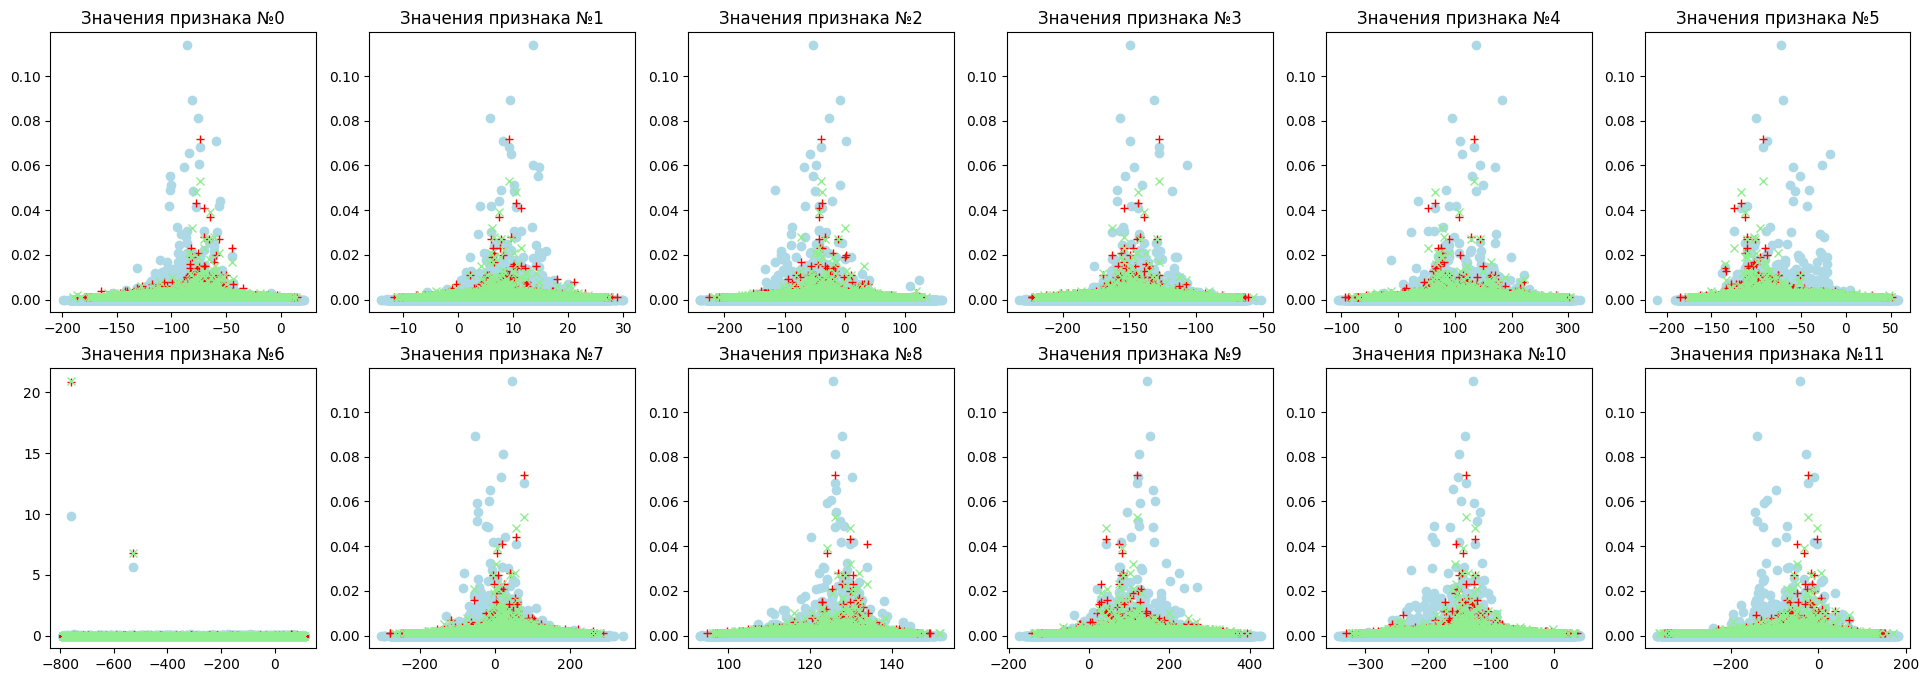

In [75]:
show_general_matrix(df_base, df_train, df_valid)

### Масштабирование признаков

In [ ]:
# выделение цел. признака в отдельный датасет
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [ ]:
scaler = StandardScaler()
scaler.fit(df_train)
df_train = scaler.transform(df_train)
df_train = scaler.transform(df_valid)

**Промежуточный вывод:**

Тип данных - соответствует. Все значения - это числа с плавающий запятов типа `float64`, а id товаров - данные типа `object` или `string`.

Пропуски - отсутствуют.

Выбросы / аномалии - ?

Дубликаты - отсутствуют, за исключением `Valid_answer`. Это может говорить, что одному и тому же "старому" товару, может соответствовать несколько "новых".

Масштабирование / нормализация данных -?

___

##  Поиск ближайших соседей

Принцип работы [Faiss](https://faiss.ai/index.html):
1. Отображение всех объектов (векторов) в едином пространстве
2. Деление полученного пространства на отдельные части (кластеры) при помощи спец. алгоритма библиотеки
3. Для каждого кластера происходит поиск его центра (центроида)
4. Таким образом, для нового вектора можно быстрой найти ближайших соседей, вычислив расстояние именно до центроидов (не перемножая новый вектор со всеми остальными векторами).
5. После выявления ближайшего кластера, новый вектор перемножается векторами только из этого кластера.

`FlatL2` - мера близости вектором L2-норма (евклидово расстояние). По этой причине большое значение имеет "нормализованы ли признаки?", поскольку в этой ситуации признак бóльшей величины будет играть бóльшую роль в предсказании. Но это не отображает достоверность его значимость.

`quantizer` - квантизатор, который получает на вход вектора размерностью `dimensions` и рассчитывает расстояние между ними по евклидовой норме.

`idx_l2` - пространство векторов размерностью `dimensions`, разделяемое на `n_cells` кластеров с помощью `quantizer`.

In [31]:

dimensions = df_base.shape[1] # n-мерность векторов
n_cells = 15 # кол-во кластеров на которые делится всё векторное пространство

quantizer = faiss.IndexFlatL2(dimensions)
idx_l2 = faiss.IndexIVFFlat(quantizer, dimensions, n_cells)

Функция `np.ascontiguousarray()` располагает последовательно весь массив данных в оперативной памяти.

In [32]:
# обучение делителя пространства на первых 50 тысячах объектов из df_base
idx_l2.train(np.ascontiguousarray(df_base.values[:50000, :]).astype('float32'))

# деление всех векторов по правилам, сформированным на предыдущем шаге 
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

Далее следует **процесс поиска** соседей. Дословно строчка кода звучит так: для каждого вектора из `df_train` найди по 5 ближайших векторов из `df_base` (которые уже размечены на отдельные кластеры). Результатом являются:
- `idx` - порядковые номера ближайших векторов, и
- `vectors` - значения этих векторов.

Этот процесс может быть долгим. Ориентировочное время поиска: 10 - 5 минут (для CPU). Время вычисления сильно зависит от кол-ва кластеров.

In [33]:
top_count = 5 # количество кандидатов на сопоставление
vectors, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), top_count)

print('Примеры idx :\n', idx[:3], '\n')
print('Примеры vectors :\n', vectors[:3])

Примеры idx :
 [[1480698  161948 1076334 1282393 2906566]
 [ 445586  920175 2168908 2651198  546230]
 [1659033  760940  656828 1052397 1392119]] 

Примеры vectors :
 [[108182.35  116295.55  125482.26  142215.5   145022.52 ]
 [102827.21  116681.83  120689.08  122624.29  122806.875]
 [ 54918.504  57053.156  57339.785  61338.43   61677.61 ]]


Для сопоставления порядкового номера вектора (`161948`) и id товара (`'161948-base'`), необходимо создать словарь:

In [34]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

print('Пример содержания словаря:\n', list(base_index.items())[0:3])

Пример содержания словаря:
 [(0, '0-base'), (1, '1-base'), (2, '2-base')]


`targets` - список `id` товаров, подходящих по мнению экспертов. (одномерный массив)

`idx` - наборы из top-5 кандидатов на соответствие, предсказанных **МБС** (метод ближайших соседей). Для получения `id` товара, нужно указать числовой индекс в словаре `base_index`. 

In [39]:
acc = 0
for target, candidates in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[number] for number in candidates])

print('accuracy@5: {}%'.format(acc / len(idx) * 100))

accuracy@5: 11.645%


На этом этапе получилось найти top-5 кандидатов для сопоставления. Теперь среди них необходимо выявить самый подходящий. Для этого всех кандидатов необходимо отранжировать.

## Ранжирование